In [1]:
from image.segmentation import BasicImageSegmenter
from ml.pipeline import KatherDataPipeline

from tensorflow.keras.applications import ResNet50

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import schedules

from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow import keras

from cfg import *

from livelossplot import PlotLossesKerasTF

import os
print(os.getcwd())
os.chdir('/home/jelinek/recetox/')


model_name = 'ResNet50_ImagenetWeightsTrainLast'

/home/jelinek/recetox/src/notebooks


In [2]:
class MyResNet50(KatherDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params. name = model_name
        self.params.batch_size = 16

        lr_schedule = schedules.ExponentialDecay(
                        initial_learning_rate=1e-1,
                        decay_steps=80,
                        decay_rate=0.1,
                        staircase=True)

        self.optimizer = ( Adam(
            learning_rate=lr_schedule,
            beta_1=0.99,
            beta_2=0.9999))


    @staticmethod
    def get_compiled_model():
        base_model = ResNet50(include_top=False,
                      input_shape=(256, 256, 3),
                      weights=None,
                      pooling=None
                      )
        base_model.trainable = True

        inputs = keras.Input(shape=(256, 256, 3))
        x = base_model(inputs, training=True)
        x = keras.layers.GlobalAveragePooling2D(name='avg_pool')(x)
        outputs = keras.layers.Dense(12, activation='softmax', name='probs')(x)

        model = keras.Model(inputs, outputs)

        return model

    def _train_model(self, data_train, data_valid):

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=30, min_lr=1e-4, verbose=1,
                                      cooldown=20)

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=200,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=10,
                       verbose=1,
                       callbacks=[self.tensorboard, reduce_lr, PlotLossesKerasTF()])

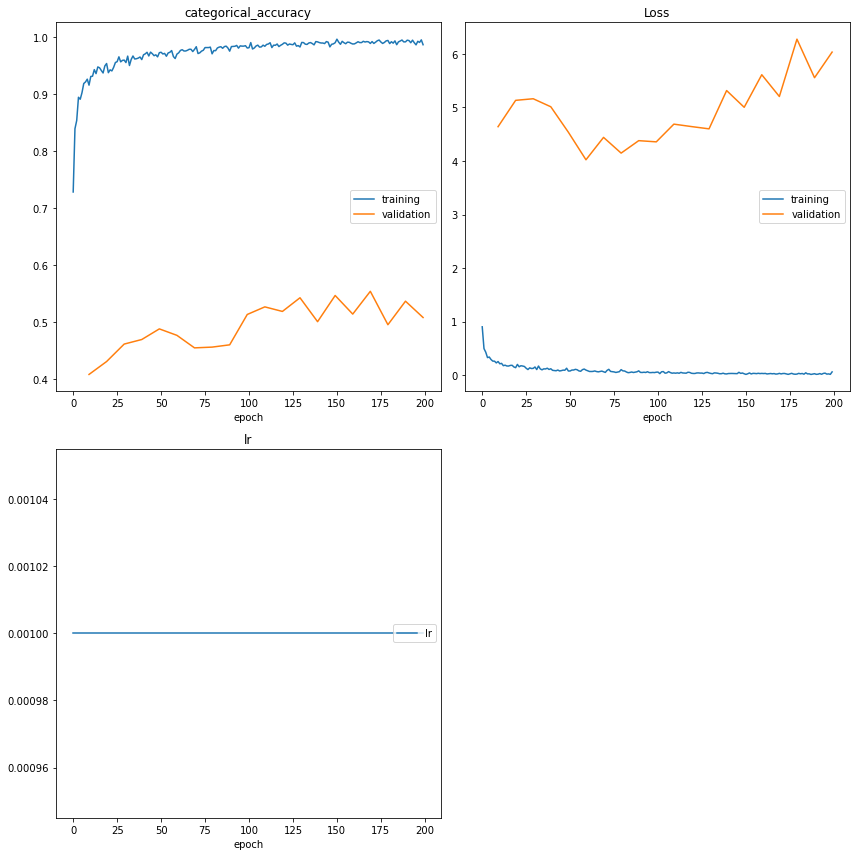

categorical_accuracy
	training         	 (min:    0.728, max:    0.996, cur:    0.987)
	validation       	 (min:    0.408, max:    0.554, cur:    0.508)
Loss
	training         	 (min:    0.014, max:    0.904, cur:    0.062)
	validation       	 (min:    4.023, max:    6.276, cur:    6.034)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
94/94 [==============================] - 30s 314ms/step - loss: 6.0343 - categorical_accuracy: 0.5077

In [3]:
pipeline = MyResNet50(train_data_dir='data/Feit_colon-annotation-tiles-256-1-neighborhood/data_train/',
                      valid_data_dir='data/Feit_colon-annotation-tiles-256-1-neighborhood/data_valid/')

pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [4]:
pipeline.save_pipeline()

/home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [5]:
pipeline = KatherDataPipeline.load_pipeline(model_name)
pipeline.perform_segmentation(step=30)

Segmenting file 1 out of 10


ValueError: in user code:

    /home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1569 predict_function  *
        return step_function(self, iterator)
    /home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1559 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1285 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2833 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3608 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1552 run_step  **
        outputs = model.predict_step(data)
    /home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1525 predict_step
        return self(x, training=False)
    /home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:1013 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/jelinek/anaconda3/envs/recetox/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:267 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model: expected shape=(None, 256, 256, 3), found shape=(None, 150, 150, 3)


In [ ]:
pipeline = KatherDataPipeline.load_pipeline(model_name)
kmeans_in = pipeline.get_data_loader_training().datagen_train.flow_from_directory('data/data_tiles_train',
                                     color_mode="rgb",
                                     class_mode=None,
                                     batch_size=8,
                                     target_size=(64, 64),
                                     shuffle=False,
                                     classes=['01_TUMOR', '02_STROMA',
                                              '03_COMPLEX', '04_LYMPHO',
                                              '05_DEBRIS', '06_MUCOSA'])
